In [8]:

!pip install wandb --quiet
import wandb
wandb.login(key="b95aafae425edf07eab77afd39e1a778180998fe")



wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip -O nature_12K.zip
!unzip -q nature_12K.zip

--2025-04-19 17:07:05--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  41.4MB/s    in 90s     

2025-04-19 17:08:35 (40.4 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]

replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace inaturalist_12K/train/Plantae/1dfc3916ad58af6ce9af9fc8b36ceedd.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.utils import shuffle # for shuffling
import os
import cv2
import random
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split




class CNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        filters = self.get_filter_list(config['filter_organisation'], config['total_filters'])
        activation = self.get_activation(config['activation'])
        self.use_bn = config['batch_normalisation'] == 'Yes'

        # Getting kernel sizes from config or using default pattern
        if 'kernel_sizes' in config:
            kernel_sizes = config['kernel_sizes']
        else:
            # By default all are set to 3
            kernel_sizes = [3, 3, 3, 3, 3]


        assert len(kernel_sizes) == 5, "Must provide exactly 5 kernel sizes for 5 conv layers"

        # 5 conv-activation-maxpool blocks
        self.conv1 = nn.Conv2d(3, filters[0], kernel_size=kernel_sizes[0], padding=kernel_sizes[0]//2)
        self.bn1 = nn.BatchNorm2d(filters[0])
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_size=kernel_sizes[1], padding=kernel_sizes[1]//2)
        self.bn2 = nn.BatchNorm2d(filters[1])
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(filters[1], filters[2], kernel_size=kernel_sizes[2], padding=kernel_sizes[2]//2)
        self.bn3 = nn.BatchNorm2d(filters[2])
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(filters[2], filters[3], kernel_size=kernel_sizes[3], padding=kernel_sizes[3]//2)
        self.bn4 = nn.BatchNorm2d(filters[3])
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(filters[3], filters[4], kernel_size=kernel_sizes[4], padding=kernel_sizes[4]//2)
        self.bn5 = nn.BatchNorm2d(filters[4])
        self.pool5 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(filters[4]*7*7, config['dense_layer_size'])
        self.dropout = nn.Dropout(config['dropout'])
        self.fc2 = nn.Linear(config['dense_layer_size'], 10)  # 10 output neurons
        self.activation = activation

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn: x = self.bn1(x)
        x = self.activation(x)
        x = self.pool1(x)

        x = self.conv2(x)
        if self.use_bn: x = self.bn2(x)
        x = self.activation(x)
        x = self.pool2(x)

        x = self.conv3(x)
        if self.use_bn: x = self.bn3(x)
        x = self.activation(x)
        x = self.pool3(x)

        x = self.conv4(x)
        if self.use_bn: x = self.bn4(x)
        x = self.activation(x)
        x = self.pool4(x)

        x = self.conv5(x)
        if self.use_bn: x = self.bn5(x)
        x = self.activation(x)
        x = self.pool5(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.activation(self.fc1(x))
        return self.fc2(x)

    def get_filter_list(self, mode, base):
        factor = {'same': 1, 'double': 2, 'half': 0.5}[mode]
        return [
            base,
            int(base*factor),
            int(base*(factor**2)),
            int(base*(factor**3)),
            int(base*(factor**4))
        ]

    def get_activation(self, name):
        return {
            'ReLU': nn.ReLU(),
            'GELU': nn.GELU(),
            'SiLU': nn.SiLU(),
            'Mish': nn.Mish(),
            'ELU': nn.ELU(),
            'SELU': nn.SELU()
        }[name]

In [11]:

def load_data(image_size, aug, batch_size, data_path="/content/inaturalist_12K"):

    from torchvision.datasets import ImageFolder
    normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])

    base_tfms = [transforms.Resize((image_size, image_size)), transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        *base_tfms
    ]) if aug == 'Yes' else transforms.Compose(base_tfms)

    test_tfms = transforms.Compose(base_tfms)

    train_dataset = ImageFolder(os.path.join(data_path, 'train'), transform=train_tfms)
    test_dataset = ImageFolder(os.path.join(data_path, 'val'), transform=test_tfms)


    from sklearn.model_selection import StratifiedShuffleSplit
    from torch.utils.data import Subset
    import numpy as np

    targets = [s[1] for s in train_dataset.samples]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=2000, random_state=42)
    train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))
    train_dataset = Subset(train_dataset, train_idx)
    val_dataset = Subset(train_dataset.dataset, val_idx)


    classes = train_dataset.dataset.classes

    return classes, DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size), DataLoader(test_dataset, batch_size=batch_size)




import torch

# Set the device to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Using device: cuda


Epoch 1/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch 1 - Train Loss: 2.3377, Train Acc: 0.2050 | Val Loss: 2.0129, Val Acc: 0.2770


Epoch 2/20 - Validation: 100%|██████████| 16/16 [00:33<00:00,  2.12s/it]


Epoch 2 - Train Loss: 1.9942, Train Acc: 0.2930 | Val Loss: 1.9497, Val Acc: 0.3090


Epoch 3/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch 3 - Train Loss: 1.9414, Train Acc: 0.3070 | Val Loss: 1.9169, Val Acc: 0.3240


Epoch 4/20 - Validation: 100%|██████████| 16/16 [00:30<00:00,  1.88s/it]


Epoch 4 - Train Loss: 1.8742, Train Acc: 0.3399 | Val Loss: 1.8775, Val Acc: 0.3515


Epoch 5/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


Epoch 5 - Train Loss: 1.8177, Train Acc: 0.3579 | Val Loss: 1.8941, Val Acc: 0.3410


Epoch 6/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch 6 - Train Loss: 1.7743, Train Acc: 0.3692 | Val Loss: 1.8658, Val Acc: 0.3505


Epoch 7/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.75s/it]


Epoch 7 - Train Loss: 1.7370, Train Acc: 0.3862 | Val Loss: 1.8486, Val Acc: 0.3575


Epoch 8/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


Epoch 8 - Train Loss: 1.7072, Train Acc: 0.4017 | Val Loss: 1.8072, Val Acc: 0.3800


Epoch 9/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Epoch 9 - Train Loss: 1.6560, Train Acc: 0.4199 | Val Loss: 1.8387, Val Acc: 0.3675


Epoch 10/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


Epoch 10 - Train Loss: 1.6155, Train Acc: 0.4288 | Val Loss: 1.7842, Val Acc: 0.3875


Epoch 11/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch 11 - Train Loss: 1.5875, Train Acc: 0.4434 | Val Loss: 1.7226, Val Acc: 0.3950


Epoch 12/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


Epoch 12 - Train Loss: 1.5379, Train Acc: 0.4579 | Val Loss: 1.7491, Val Acc: 0.3960


Epoch 13/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]


Epoch 13 - Train Loss: 1.5029, Train Acc: 0.4727 | Val Loss: 1.8390, Val Acc: 0.3685


Epoch 14/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Epoch 14 - Train Loss: 1.4626, Train Acc: 0.4852 | Val Loss: 1.7665, Val Acc: 0.4040


Epoch 15/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Epoch 15 - Train Loss: 1.4288, Train Acc: 0.5019 | Val Loss: 1.7498, Val Acc: 0.3980


Epoch 16/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]


Epoch 16 - Train Loss: 1.3941, Train Acc: 0.5218 | Val Loss: 1.7858, Val Acc: 0.3980


Epoch 17/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Epoch 17 - Train Loss: 1.3528, Train Acc: 0.5339 | Val Loss: 1.7180, Val Acc: 0.4220


Epoch 18/20 - Validation: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch 18 - Train Loss: 1.3262, Train Acc: 0.5456 | Val Loss: 1.8490, Val Acc: 0.3985


Epoch 19/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch 19 - Train Loss: 1.2840, Train Acc: 0.5541 | Val Loss: 1.8014, Val Acc: 0.4065


Epoch 20/20 - Validation: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


Epoch 20 - Train Loss: 1.2439, Train Acc: 0.5693 | Val Loss: 1.7434, Val Acc: 0.4205
Best model saved to best_model.pth with validation accuracy: 0.4220


Testing: 100%|██████████| 16/16 [00:30<00:00,  1.91s/it]


Test Accuracy: 0.4265


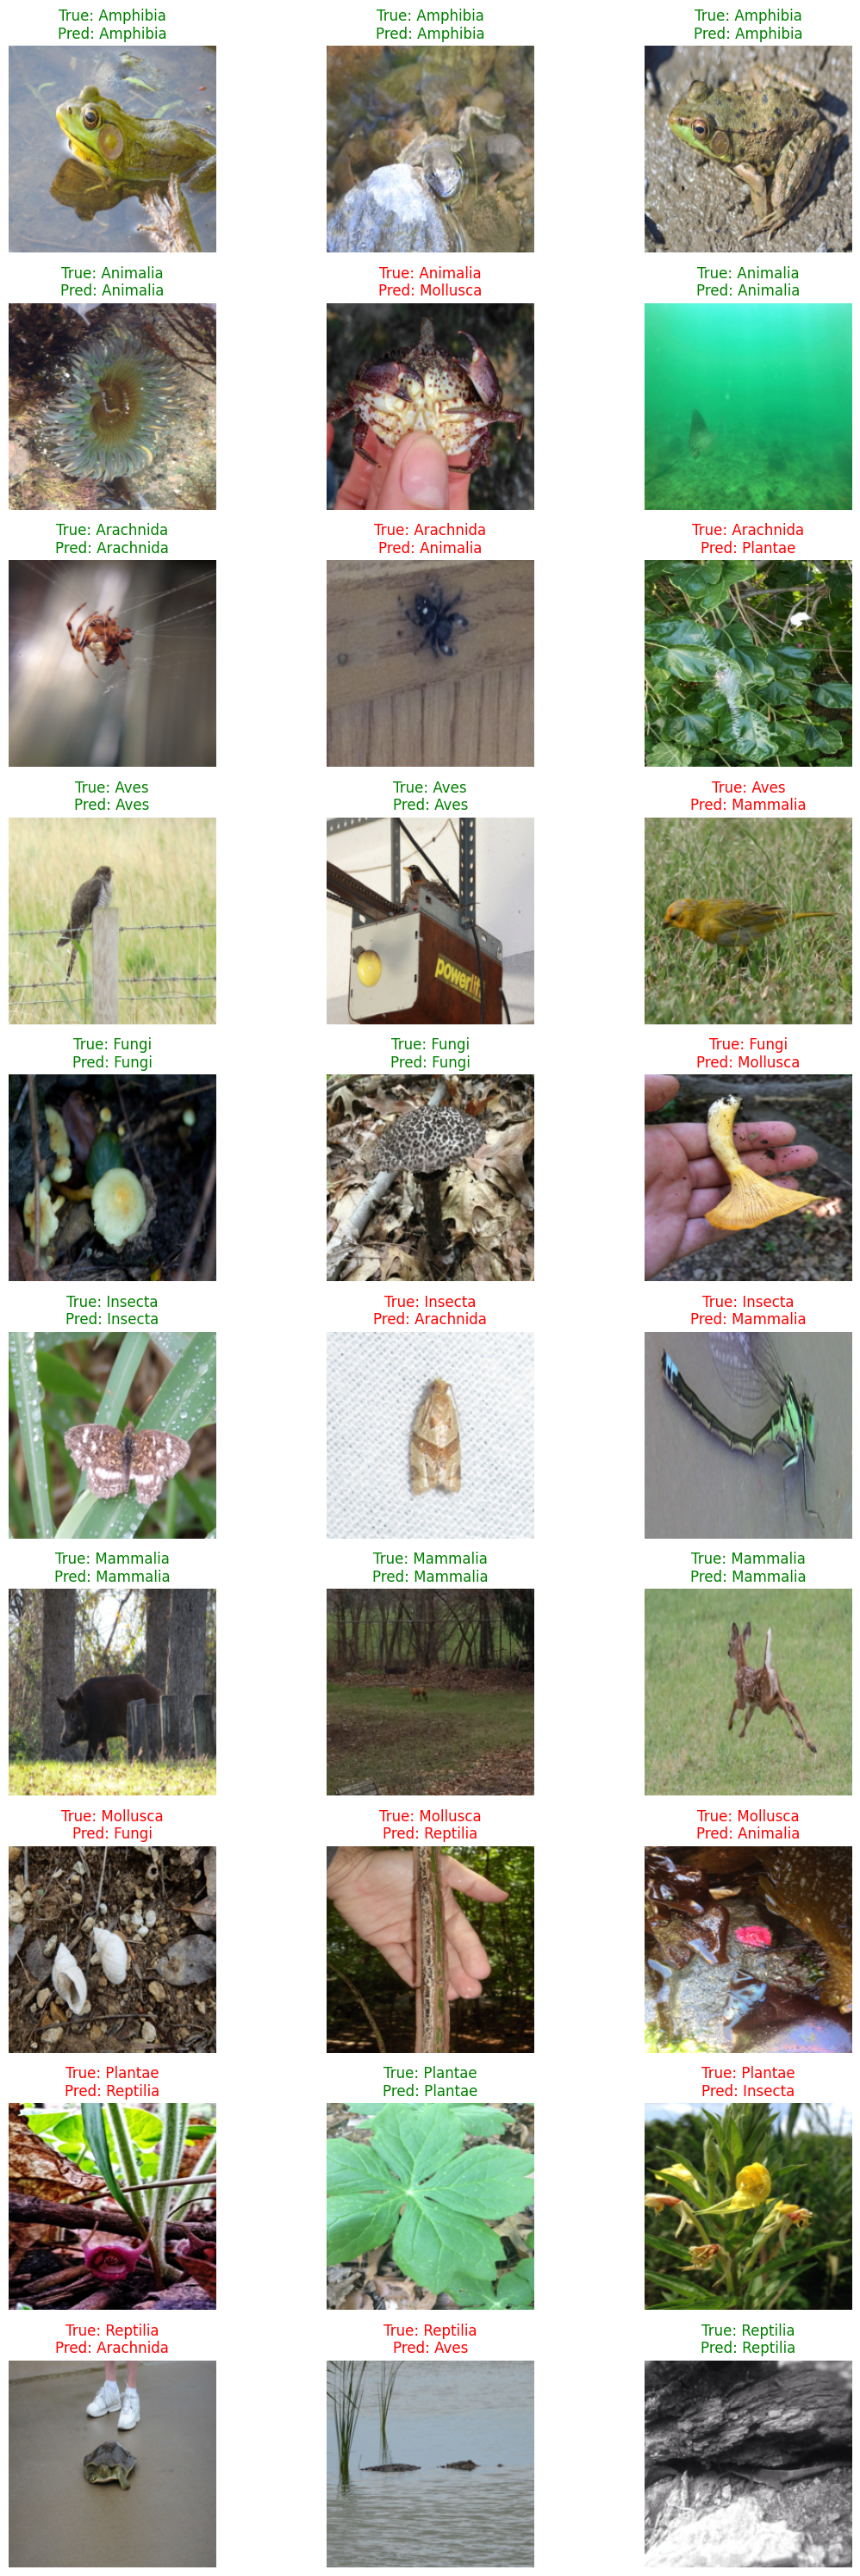

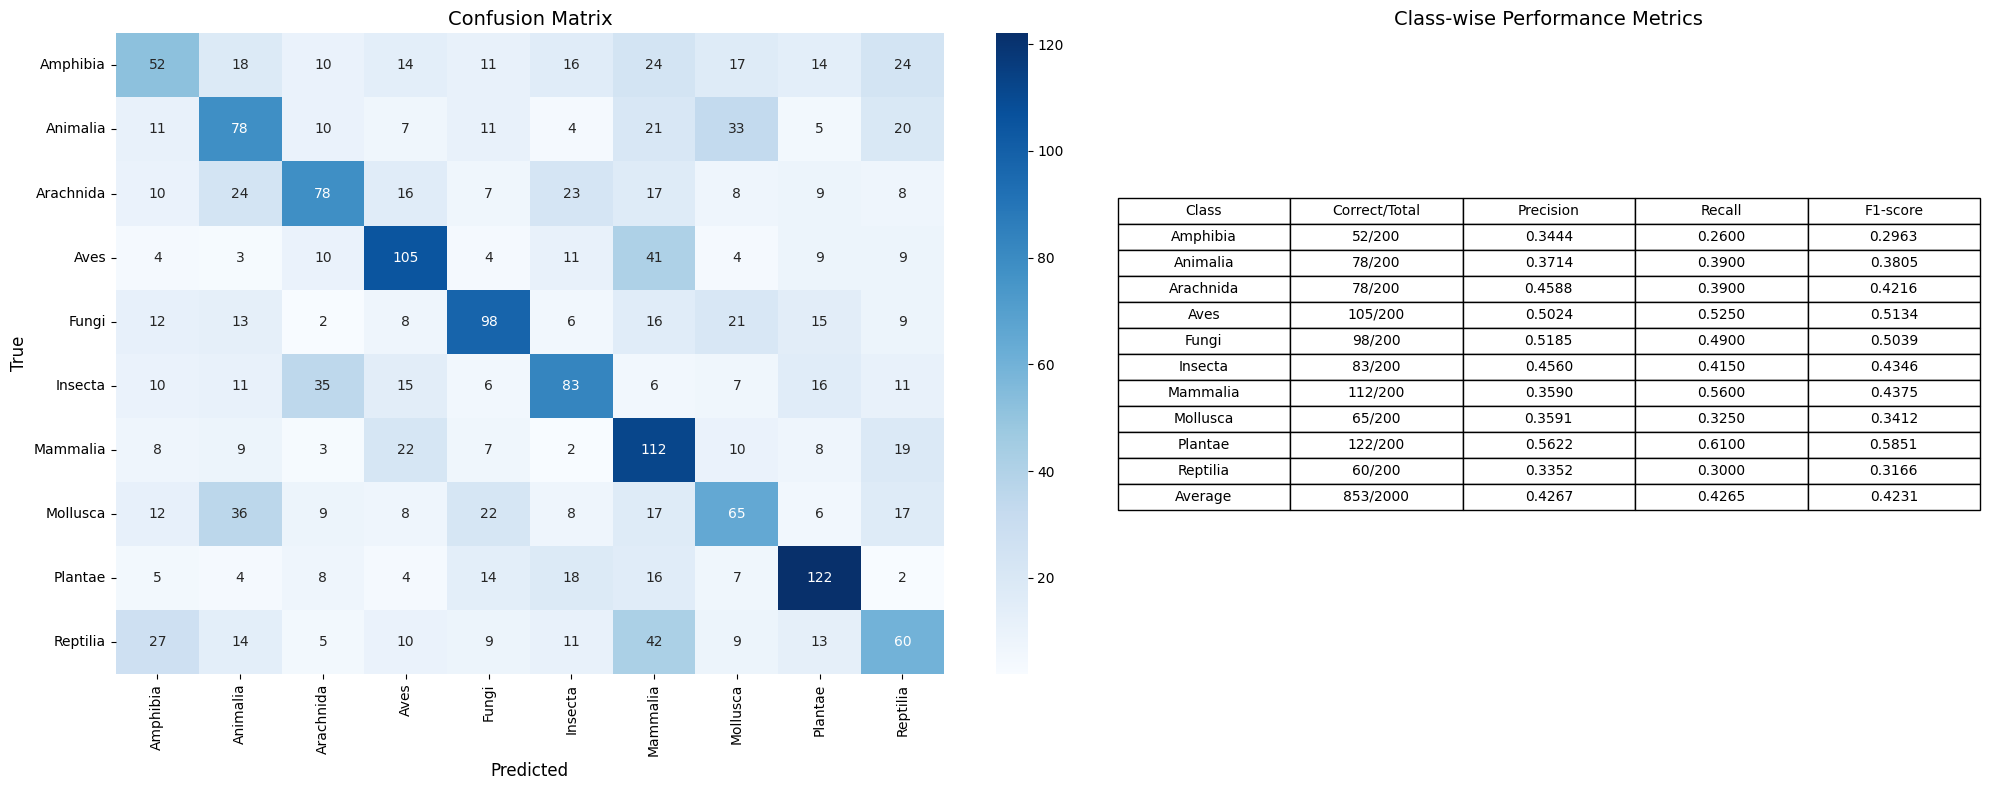

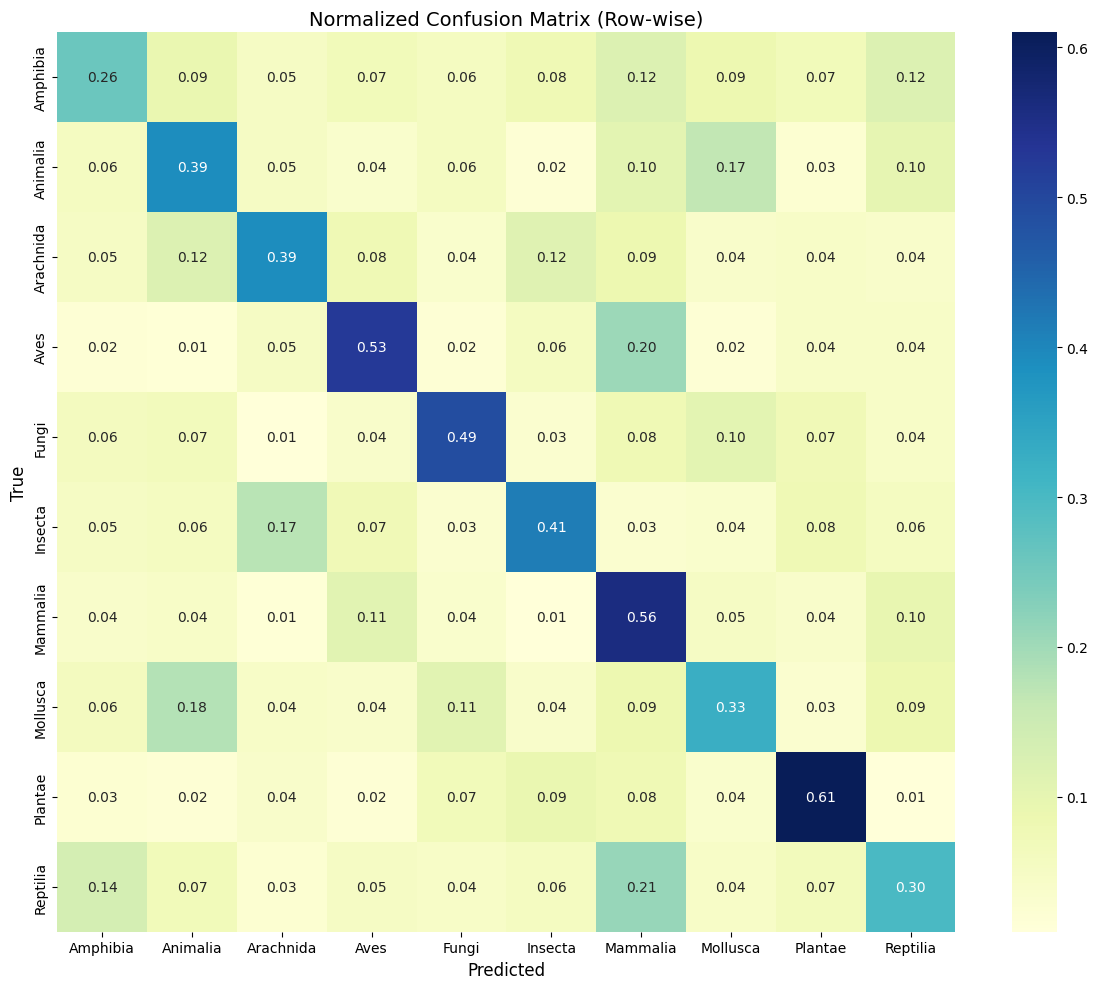

Final test accuracy: 0.4265


In [13]:

def train_model(config=None, use_wandb=True, save_best=False, save_path="best_model.pth"):

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if use_wandb:
        with wandb.init(config=config, project="DA6401_A2_PartA"):
            config = wandb.config

            # Update run name of wandb after initialization
            new_name = f"{config.optimizer}-{config.activation}-{config.filter_organisation}-{config.batch_size}"
            wandb.run.name = new_name

            return _train_core(config, use_wandb, save_best, save_path)
    else:

        return _train_core(config, use_wandb, save_best, save_path)

def _train_core(config, use_wandb=True, save_best=False, save_path="best_model.pth"):


    if isinstance(config, dict):
        aug = config.get('augmentation', 'Yes')
        batch_size = config.get('batch_size', 64)
        epochs = config.get('epochs', 10)
        optimizer_name = config.get('optimizer', 'adam').lower()
        lr = config.get('learning_rate', 0.001)
        weight_decay = config.get('weight_decay', 0.0001)
    else:
        # wandb.config
        aug = getattr(config, 'augmentation', 'Yes')
        batch_size = config.batch_size
        epochs = config.epochs
        optimizer_name = config.optimizer.lower()
        lr = config.learning_rate
        weight_decay = config.weight_decay

    # Load data
    classes, train_loader, val_loader, test_loader = load_data(
        image_size=224,
        aug=aug,
        batch_size=batch_size
    )


    model = CNN(config).to(device)

    # Setup optimizer
    optimizer_map = {
        'adam': torch.optim.Adam,
        'sgd': torch.optim.SGD,
        'nadam': torch.optim.NAdam,
        'adamw': torch.optim.AdamW,
        'rmsprop': torch.optim.RMSprop
    }

    optimizer_class = optimizer_map[optimizer_name]
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    # Tracking best model
    best_val_acc = 0
    best_model_state = None

    # Training loop
    for epoch in range(epochs):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            del X, y, outputs, loss, preds

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        val_running_loss = 0.0

        with torch.no_grad():
            for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                X, y = X.to(device), y.to(device)
                outputs = model(X)

                val_loss = criterion(outputs, y)
                val_running_loss += val_loss.item()
                val_correct += (outputs.argmax(1) == y).sum().item()
                val_total += y.size(0)
                del X, y, outputs, val_loss

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        # Log metrics
        if use_wandb:
            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            })

        # print(f"Epoch {epoch+1} - Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Saving best model
        if save_best and val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

    # Load best model state
    if save_best and best_model_state is not None:
        model.load_state_dict(best_model_state)
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'classes': classes
        }, save_path)
        print(f"Best model saved to {save_path} with validation accuracy: {best_val_acc:.4f}")

    return model, classes, test_loader


def test_model(model=None, test_loader=None, classes=None, model_path="best_model.pth"):

    if model is None:
        # Load saved model
        checkpoint = torch.load(model_path)
        config = checkpoint['config']
        classes = checkpoint['classes']

        model = CNN(config).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])

        _, _, _, test_loader = load_data(
            image_size=224,
            aug='No',  # No augmentation for testing
            batch_size=64
        )

    model.eval()
    test_correct, test_total = 0, 0
    all_preds = []
    all_targets = []
    all_images = []

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Testing"):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)

            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

            # Store predictions and targets for visualization
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            all_images.extend(X.cpu().numpy())

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy, all_preds, all_targets, all_images, classes

def visualize_predictions(all_images, all_preds, all_targets, classes, samples_per_class=2):

    # Convert images from normalized tensors back to displayable format
    def denormalize(x):
        # Assuming normalization was done with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        x = x * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
        return np.clip(x.transpose(1, 2, 0), 0, 1)

    # Create a figure with subplots - samples_per_class samples per class
    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class*4, n_classes*3))

    for class_idx in range(n_classes):
        # Find indices where the true class is class_idx
        indices = np.where(np.array(all_targets) == class_idx)[0]

        if len(indices) < samples_per_class:
            print(f"Warning: Class {class_idx} ({classes[class_idx]}) has less than {samples_per_class} samples")
            samples = indices
        else:
            # Randomly select samples_per_class samples
            samples = np.random.choice(indices, samples_per_class, replace=False)

        for i, sample_idx in enumerate(samples):
            if samples_per_class == 1:
                ax = axes[class_idx]
            else:
                ax = axes[class_idx, i]

            # Display the image
            img = denormalize(all_images[sample_idx])
            ax.imshow(img)

            # Set title with true and predicted class
            true_class = classes[all_targets[sample_idx]]
            pred_class = classes[all_preds[sample_idx]]

            title = f"True: {true_class}\nPred: {pred_class}"
            if true_class == pred_class:
                ax.set_title(title, color='green')
            else:
                ax.set_title(title, color='red')

            ax.axis('off')

    plt.tight_layout()
    plt.savefig('class_predictions.png')
    plt.show()


def visualize_confusion_matrix(all_preds, all_targets, classes):

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Calculate class-wise metrics
    precision = precision_score(all_targets, all_preds, average=None, zero_division=0)
    recall = recall_score(all_targets, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_targets, all_preds, average=None, zero_division=0)

    # Create a figure with two subplots - confusion matrix and metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1.2, 1]})

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_xlabel('Predicted', fontsize=12)
    ax1.set_ylabel('True', fontsize=12)
    ax1.set_title('Confusion Matrix', fontsize=14)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Convert NaN to 0

    # Create a table with metrics
    metrics_data = []
    for i, class_name in enumerate(classes):
        metrics_data.append([
            class_name,
            f"{cm[i, i]}/{sum(cm[i, :])}",
            f"{precision[i]:.4f}",
            f"{recall[i]:.4f}",
            f"{f1[i]:.4f}"
        ])

    # Add average metrics
    avg_precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    avg_recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    avg_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    metrics_data.append([
        "Average",
        f"{np.sum(np.diag(cm))}/{len(all_targets)}",
        f"{avg_precision:.4f}",
        f"{avg_recall:.4f}",
        f"{avg_f1:.4f}"
    ])

    # Create table for metrics
    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(
        cellText=metrics_data,
        colLabels=["Class", "Correct/Total", "Precision", "Recall", "F1-score"],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)


    ax2.set_title('Class-wise Performance Metrics', fontsize=14)

    plt.tight_layout()
    plt.savefig('detailed_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='YlGnBu',
        xticklabels=classes,
        yticklabels=classes
    )
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Normalized Confusion Matrix (Row-wise)', fontsize=14)
    plt.tight_layout()
    plt.savefig('normalized_confusion_matrix.png', dpi=300)
    plt.show()

def run_wandb_sweep():
    """Run a wandb hyperparameter sweep"""
    sweep_config = {
        'name': 'optimizer-activation-filter_organisation-batchsize',
        'method': 'bayes',
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'parameters': {
            'epochs': {'values': [5, 10, 15]},
            'batch_size': {'values': [32, 64, 128]},
            'learning_rate': {'min': 1e-5, 'max': 1e-3},
            'dropout': {'values': [0.1, 0.3]},
            'optimizer': {'values': ['adam', 'sgd', 'nadam', 'adamw', 'rmsprop']},
            'activation': {'values': ['ReLU', 'GELU', 'Mish', 'SiLU', 'ELU', 'SELU']},
            'augmentation': {'values': ['Yes', 'No']},
            'filter_organisation': {'values': ['same', 'double', 'half']},
            'dense_layer_size': {'values': [256, 512, 1024]},
            'total_filters': {'values': [32, 64]},
            'output_size': {'value': 10},  # Assuming 10 classes
            'batch_normalisation': {'values': ['Yes', 'No']},
            'weight_decay': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 1e-2},
            'kernel_sizes': {
                'values': [
                    [3, 3, 3, 3, 3],  # All 3x3 kernels
                    [5, 5, 5, 5, 5],  # All 5x5 kernels
                    [3, 5, 3, 5, 3],
                    [5, 3, 5, 3, 5],
                    [3, 3, 5, 5, 7],  # Starting with small kernels, increasing to larger
                    [7, 5, 5, 3, 3],  # Starting with large kernels, decreasing to smaller
                    [3, 5, 7, 5, 3],
                    [3, 5, 7, 11, 11],
                    [11, 9, 7, 5, 3],
                    [7, 5, 3, 5, 7],
                ]
            }
        }
    }

    sweep_id = wandb.sweep(sweep=sweep_config, project="DA6401_A2_PartA")
    wandb.agent(sweep_id, function=train_model, count=40)

def train_and_evaluate_specific_model():
    """Train and evaluate a model with specific configuration"""
    # Define specific configuration
    specific_config = {
        'epochs': 20, # for the highest val_accuracy i am increasing the epoch from 10 to 20 and taking same config to run the best hyperparameters
        'batch_size': 128,
        'learning_rate': 0.00029492,
        'dropout': 0.3,
        'optimizer': 'adam',
        'activation': 'SiLU',
        'augmentation': 'Yes',
        'filter_organisation': 'double',
        'dense_layer_size': 512,
        'total_filters': 32,
        'output_size': 10,
        'batch_normalisation': 'Yes',
        'weight_decay': 0.0014447,
        'kernel_sizes': [7,5,5,3,3]
    }

    # Train the model with specific configuration
    model, classes, test_loader = train_model(
        config=specific_config,
        use_wandb=False,
        save_best=True
    )

    # Test the model and get metrics
    test_accuracy, all_preds, all_targets, all_images, classes = test_model(
        model=model,
        test_loader=test_loader,
        classes=classes
    )

    # Visualize results
    visualize_predictions(all_images, all_preds, all_targets, classes, samples_per_class=3)
    visualize_confusion_matrix(all_preds, all_targets, classes)

    return model, test_accuracy


if __name__ == "__main__":
    import torch
    import torch.nn as nn
    import gc
    import copy
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import wandb
    from tqdm import tqdm
    from sklearn.metrics import confusion_matrix

    # Ensure device is set
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Choose whether to run sweep or specific model
    run_sweep = False  # Set to True to run wandb sweep, False for specific model
    # run_sweep = True
    if run_sweep:
        run_wandb_sweep()
    else:
        model, accuracy = train_and_evaluate_specific_model()
        print(f"Final test accuracy: {accuracy:.4f}")